# Simple forward with overthrust

This tutorial was prepared by Alexandre Olender. If you have any questions, please email: olender@usp.br

Here, we continue focusing on solving the acoustic wave equation using Spyro's `AcousticWave` class. Our main objective is to familiarize you with the initial dictionary inputs, which (together with the **simple forward tutorial**) should be enough if you are an end-user only interested in the results of the forward propagation methods already implemented in our software. Unlike the **simple forward tutorial**, this also loads a heterogeneous velocity model and unstructured mesh files.

If you need more control over meshing, please refer to our meshing tutorial. For more examples of simple cases usually encountered in seismic imaging, please refer to the tutorial on using **pre-made useful examples**. If you are interested in developing code for Spyro, both the **altering time integration** and the **altering variational equation** tutorials suit you.

We currently have a **simple FWI** and **detailed synthetic FWI** tutorials for inversion-based tutorials.

If you are running this notebook in Google colab, please copy the following code into a code block before running the notebook:
```python
# For use in colab only:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

!pip install git+https://github.com/NDF-Poli-USP/spyro.git

In [ ]:
# Code in this cell enables plotting in the notebook
%matplotlib inline

We begin by making Spyro available in our notebook. This step is necessary for every python package.

In [2]:
import spyro
import numpy as np

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


Now, we begin to define our problem parameters. This can be done using a python dictionary.

In [3]:
dictionary = {}

The first dictionary deals with basic finite element options. Here, we will use T for a triangle as our cell type (try typing out triangle instead of T; it still should work). Lumped triangles (or tetrahedra) use specific quadrature and collocation nodes to have diagonal mass matrices. We have chosen 4th-order elements since they generally perform much better than elements of order 1, 2, 3, and 5 when paired with waveform-adapted meshes. For more details on this choice, we direct you to the Spyro paper at https://gmd.copernicus.org/articles/15/8639/2022/gmd-15-8639-2022.html. We also have support for newer 6th-order elements. The choice between the 4th and 6th orders is more complicated and hardware-dependent and not the focus of this tutorial.

In [4]:
dictionary["options"] = {
    "cell_type": "T",  # simplexes such as triangles or tetrahedra (T) or quadrilaterals (Q)
    "variant": "lumped",  # lumped, equispaced or DG, default is lumped
    "degree": 4,  # p order
    "dimension": 2,  # dimension
}

Next, we define our parallelism type. Let us stick with automatic for now.

In [5]:
dictionary["parallelism"] = {
    "type": "automatic",  # options: automatic (same number of cores for evey processor) or spatial
}

We must also define our mesh parameters, such as size in every axis. Here, we define our mesh file location (we accept every mesh input Firedrake accepts). We will use a waveform-adapted triangular mesh already built specifically for our velocity model. This unstructured mesh allows us to adapt and increase element sizes across the domain. Therefore, with our higher-order elements, we significantly reduce degrees of freedom, computational runtime, and error compared with standard lower-order methods.

In [6]:
dictionary["mesh"] = {
    "Lz": 2.8,  # depth in km - always positive   # Como ver isso sem ler a malha?
    "Lx": 6.0,  # width in km - always positive
    "Ly": 0.0,  # thickness in km - always positive
    "mesh_file": "meshes/cut_overthrust.msh",
}

We also have to define our acquisition geometry for receivers and sources. Sources for this kind of model tend to be located on the water layer near the top, and receivers can be located anywhere on the water layer but are usually right at the end of it. The setup varies considerably based on the type of acquisition geometry you are trying to model. You will also notice we are choosing to use only one source. This is to simplify computational requirements for this notebook. Try multiple sources using various cores to check out our parallelism strategy and performance. This experiment is the focus of a future tutorial.

In [7]:
dictionary["acquisition"] = {
    "source_type": "ricker",
    "source_locations": [(-0.01, 3.0)],
    "frequency": 5.0,
    "receiver_locations": spyro.create_transect((-0.37, 0.2), (-0.37, 5.8), 300),
}

This overthrust model also has a perfectly matched 750-meter layer to absorb outgoing waves on every side except the top.

In [8]:
dictionary["absorving_boundary_conditions"] = {
    "status": True,
    "damping_type": "PML",
    "exponent": 2,
    "cmax": 4.5,
    "R": 1e-6,
    "pad_length": 0.75,
}


We also have to load the velocity model file

In [9]:
dictionary["synthetic_data"] = {
    "real_velocity_file": "velocity_models/cut_overthrust.hdf5",
}

Our time domain inputs:

In [10]:
dictionary["time_axis"] = {
    "initial_time": 0.0,  # Initial time for event
    "final_time": 5.00,  # Final time for event
    "dt": 0.0005,  # timestep size
    "output_frequency": 200,  # how frequently to output solution to pvds - Perguntar Daiane ''post_processing_frequnecy'
    "gradient_sampling_frequency": 1,  # how frequently to save solution to RAM    - Perguntar Daiane 'gradient_sampling_frequency'
}

We can also define where we want everything to be saved. If left blank, most of these options will be replaced with default values.

In [11]:
dictionary["visualization"] = {
    "forward_output": True,
    "forward_output_filename": "results/forward_output.pvd",
    "fwi_velocity_model_output": False,
    "velocity_model_filename": None,
    "gradient_output": False,
    "gradient_filename": "results/Gradient.pvd",
    "adjoint_output": False,
    "adjoint_filename": None,
    "debug_output": False,
}

We can now create our acoustic wave object.

In [12]:
Wave_obj = spyro.AcousticWave(dictionary=dictionary)

Parallelism type: automatic
INFO: Distributing 1 shot(s) across 1 core(s).                 Each shot is using 1 cores
  rank 0 on ensemble 0 owns 5976 elements and can access 3113 vertices


All we have to do now is call our forward solve method.

In [13]:
Wave_obj.forward_solve()

INFO: converting from m/s to km/s
Saving output in: results/forward_outputsn0.pvd


/home/alexandre/firedrake/src/firedrake/firedrake/assemble.py:209: DeprecationWarning: create_assembly_callable is now deprecated. Please use assemble or FormAssembler instead.
  warnings.warn("create_assembly_callable is now deprecated. Please use assemble or FormAssembler instead.",


Simulation time is:        0.0 seconds
Simulation time is:        0.1 seconds
Simulation time is:        0.2 seconds
Simulation time is:        0.3 seconds
Simulation time is:        0.4 seconds
Simulation time is:        0.5 seconds
Simulation time is:        0.6 seconds
Simulation time is:        0.7 seconds
Simulation time is:        0.8 seconds
Simulation time is:        0.9 seconds
Simulation time is:        1.0 seconds
Simulation time is:        1.1 seconds
Simulation time is:        1.2 seconds
Simulation time is:        1.3 seconds
Simulation time is:        1.4 seconds
Simulation time is:        1.5 seconds
Simulation time is:        1.6 seconds
Simulation time is:        1.7 seconds
Simulation time is:        1.8 seconds
Simulation time is:        1.9 seconds
Simulation time is:        2.0 seconds
Simulation time is:        2.1 seconds
Simulation time is:        2.2 seconds
Simulation time is:        2.3 seconds
Simulation time is:        2.4 seconds
Simulation time is:      

Let us have a look at the experiment we just ran.

File name model_overthrust.png


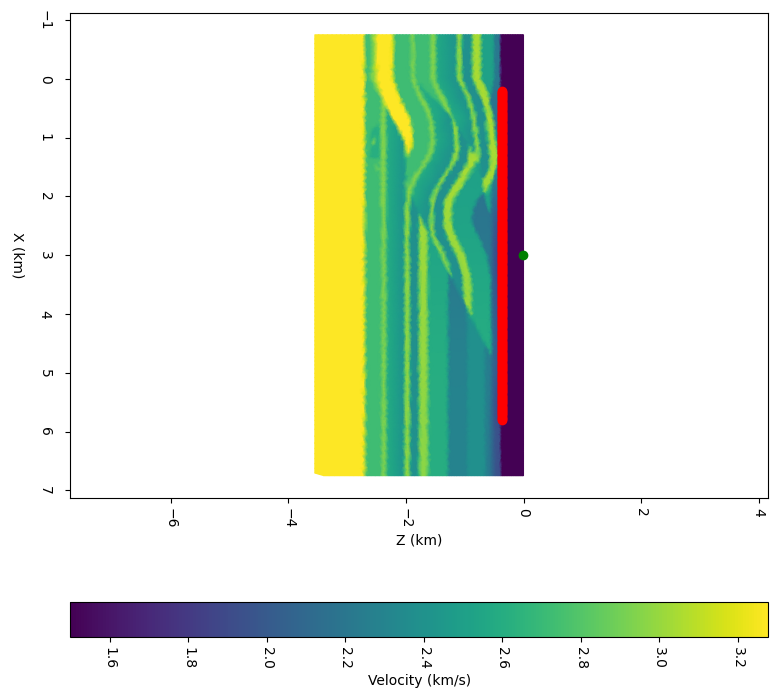

In [14]:
spyro.plots.plot_model(Wave_obj, filename="model_overthrust.png", show=True)

From the plot above, we can notice two things. First, it is rotated by 90 degrees. In cases like this, the saved PNG image will be in the correct orientation. However, the plotted image in this notebook is rotated because the velocity model we used, commonly with segy files, has the Z-axis before the X-axis in data input.

Another observation is that, unlike in the **simple forward tutorial**, we looked at the experiment layout after running the forward solve. For memory purposes, a 2D or 3D velocity file is only actually interpolated into our domain when it is necessary for another method of the Wave object class. If you need to force the interpolation sooner, call the _initialize_model_parameters() method.

It is also important to note that even though receivers look like a line, they are actually located in points, which can be visible by zooming into the image, not coinciding with nodes.

In seismic imagining, the shot record is one of the most important outputs of the forward problem. It represents the pressure values recorded at every receiver and timestep. This is the data that we will use for inversion. Shot record data is saved inside the wave object as the receivers_output attribute

In [15]:
shot_record = Wave_obj.receivers_output

Let us have a look at our shot record. For a better image, we will use 10% of the maximum value of the shot record as the maximum in our contour plot. The maximum value usually represents the direct wave, and we want more significant emphasis on the reflected waves.

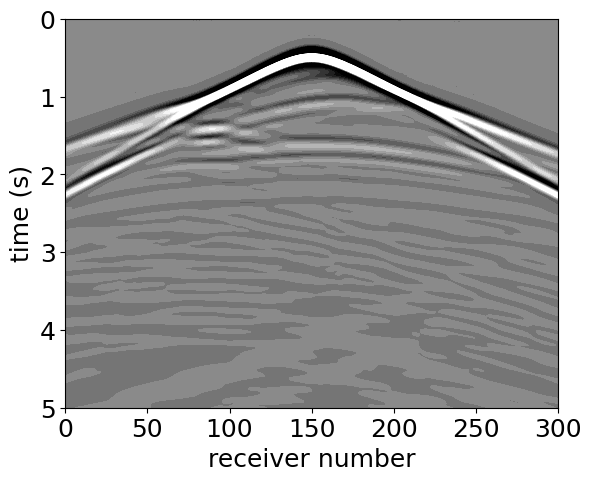

In [16]:
vmax = 0.1*np.max(shot_record)
spyro.plots.plot_shots(Wave_obj, contour_lines=100, vmin=-vmax, vmax=vmax, show=True)